In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:

file_name = 'ipl_matches_data_cleaned.csv'
df_matches = pd.read_csv(file_name, parse_dates=['match_date'])
print(f"Loaded '{file_name}'. Starting : EDA...")


Loaded 'ipl_matches_data_cleaned.csv'. Starting : EDA...



Toss Decisions:
toss_decision
field    764
bat      404
Name: count, dtype: int64
Saved toss_decision_pie_chart.png


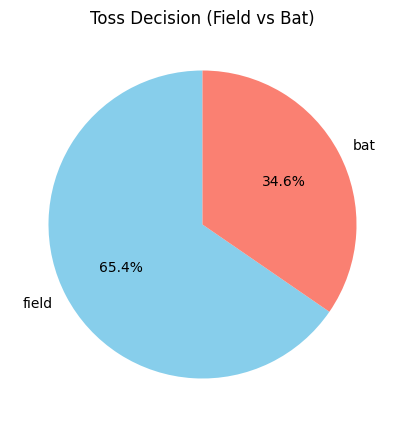

In [3]:
# --- 1. Toss Decisions (Pie Chart) ---
# We exclude 'No Toss' for this analysis
toss_decisions = df_matches[df_matches['toss_decision'] != 'No Toss']['toss_decision'].value_counts()
print(f"\nToss Decisions:\n{toss_decisions}")

plt.figure(figsize=(5, 5))
plt.pie(toss_decisions, labels=toss_decisions.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Toss Decision (Field vs Bat)')
plt.savefig('toss_decision_pie_chart.png')
print("Saved toss_decision_pie_chart.png")


Toss Impact (Percentage):
toss_win_match_win  Lost Match  Won Match
toss_decision                            
bat                  53.980100  46.019900
field                45.586298  54.413702


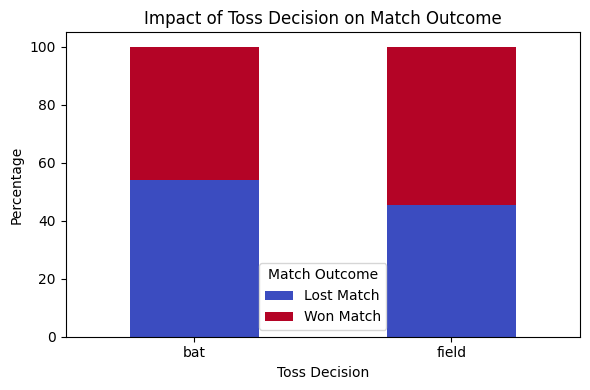

In [4]:

# --- 2. Toss Impact (Stacked Bar Chart) ---
# Create a new column to check if toss winner is match winner
df_matches['toss_win_match_win'] = (df_matches['toss_winner'] == df_matches['match_winner']).astype(int)

# We exclude 'No Result' or 'No Toss' matches
analysis_df = df_matches[df_matches['match_winner'] != 'No Result']
toss_impact = analysis_df.groupby('toss_decision')['toss_win_match_win'].value_counts(normalize=True).unstack() * 100
toss_impact = toss_impact.rename(columns={0: 'Lost Match', 1: 'Won Match'})
print(f"\nToss Impact (Percentage):\n{toss_impact}")

# Plotting the stacked bar chart
toss_impact.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='coolwarm')
plt.title('Impact of Toss Decision on Match Outcome')
plt.xlabel('Toss Decision')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(title='Match Outcome')
plt.tight_layout()
# plt.savefig('toss_impact_stacked_bar_chart.png')
# print("Saved toss_impact_stacked_bar_chart.png")



Top 10 Teams by Wins:
match_winner
Mumbai Indians                 153
Chennai Super Kings            142
Kolkata Knight Riders          135
Royal Challengers Bangalore    133
Sunrisers Hyderabad            125
Punjab Kings                   123
Delhi Capitals                 121
Rajasthan Royals               116
Gujarat Titans                  37
Lucknow Super Giants            30
Name: count, dtype: int64


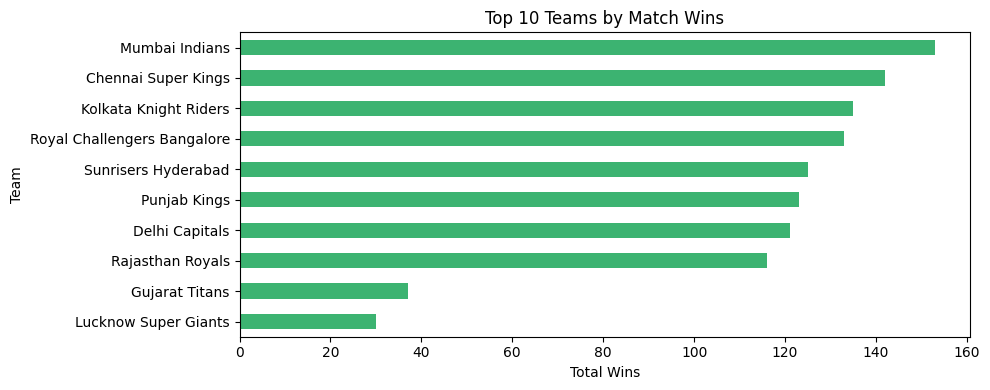

In [5]:
# --- 3. Top Teams (Bar Chart) ---
# Exclude 'No Result'
top_teams = df_matches[df_matches['match_winner'] != 'No Result']['match_winner'].value_counts().head(10)
print(f"\nTop 10 Teams by Wins:\n{top_teams}")

plt.figure(figsize=(10, 4))
# Sort ascending for horizontal bar chart
top_teams.sort_values(ascending=True).plot(kind='barh', color='mediumseagreen')
plt.xlabel('Total Wins')
plt.ylabel('Team')
plt.title('Top 10 Teams by Match Wins')
plt.tight_layout()
# plt.savefig('top_10_teams_bar_chart.png')
# print("Saved top_10_teams_bar_chart.png")


Top 10 Venues by Matches Hosted:
venue
Eden Gardens                                  77
Wankhede Stadium                              73
M Chinnaswamy Stadium                         65
Feroz Shah Kotla                              60
Wankhede Stadium, Mumbai                      52
Rajiv Gandhi International Stadium, Uppal     49
MA Chidambaram Stadium, Chepauk               48
Sawai Mansingh Stadium                        47
Dubai International Cricket Stadium           46
Punjab Cricket Association Stadium, Mohali    35
Name: count, dtype: int64


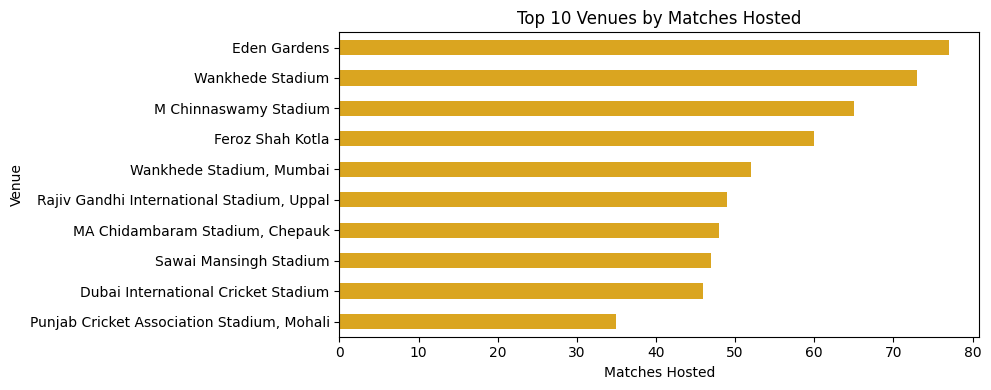

In [6]:
# --- 4. Top Venues (Bar Chart) ---
top_venues = df_matches['venue'].value_counts().head(10)
print(f"\nTop 10 Venues by Matches Hosted:\n{top_venues}")

plt.figure(figsize=(10, 4))
# Sort ascending for horizontal bar chart
top_venues.sort_values(ascending=True).plot(kind='barh', color='goldenrod')
plt.xlabel('Matches Hosted')
plt.ylabel('Venue')
plt.title('Top 10 Venues by Matches Hosted')
plt.tight_layout()
# plt.savefig('top_10_venues_bar_chart.png')
# print("Saved top_10_venues_bar_chart.png")

# *****************************************************************************************************

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, SGDRegressor
from sklearn.naive_bayes import GaussianNB

In [ ]:


# Load the newly uploaded dataset
df_matches = pd.read_csv('ipl_matches_data_cleaned.csv')

# Inspect the data
print(df_matches.head())
print(df_matches.info())
print("\nTarget Variable (match_winner) unique values:")
print(df_matches['match_winner'].unique())

   match_id  season_id       city  match_date match_type season  \
0    335982       2008  Bangalore  2008-04-18        T20   2008   
1   1082591       2017  Hyderabad  2017-04-05        T20   2017   
2   1082592       2017       Pune  2017-04-06        T20   2017   
3   1082593       2017     Rajkot  2017-04-07        T20   2017   
4   1082594       2017     Indore  2017-04-08        T20   2017   

                                       venue                  toss_winner  \
0                      M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Rajiv Gandhi International Stadium, Uppal  Royal Challengers Bangalore   
2    Maharashtra Cricket Association Stadium       Rising Pune Supergiant   
3     Saurashtra Cricket Association Stadium        Kolkata Knight Riders   
4                     Holkar Cricket Stadium                 Punjab Kings   

                         team1                        team2 toss_decision  \
0  Royal Challengers Bangalore        Kolkata Knight Ride


# --- PREPROCESSING ---

In [3]:

# Drop records where there is no winner (Draws/No Result) for clean training
df_matches = df_matches.dropna(subset=['match_winner'])

In [4]:

# Sort by date to ensure temporal training
df_matches['match_date'] = pd.to_datetime(df_matches['match_date'])
df_matches = df_matches.sort_values('match_date')


In [6]:

# Feature Selection
# We use features available *before* the match starts to predict the winner
feature_cols = ['team1', 'team2', 'toss_winner', 'toss_decision', 'venue', 'city']
target_col_class = 'match_winner'
target_col_reg = 'win_by_runs'


In [7]:
# Encode Categorical Features
le_dict = {}
for col in feature_cols + [target_col_class]:
    le = LabelEncoder()
    # Handle potential missing values in categorical columns by filling with 'Unknown'
    df_matches[col] = df_matches[col].fillna('Unknown')
    df_matches[col] = le.fit_transform(df_matches[col])
    le_dict[col] = le


In [8]:
# Define X and y
X = df_matches[feature_cols]
y_class = df_matches[target_col_class]
y_reg = df_matches[target_col_reg].fillna(0) # Fill NaN margins with 0


# --- SPLIT DATA ---

In [9]:

# Split by Season: Train on older seasons, Test on the most recent season (2024/2025)
# Let's check the unique seasons
latest_season = df_matches['season_id'].max()
print(f"Latest Season in Data: {latest_season}")

X_train = X[df_matches['season_id'] < latest_season]
y_train_class = y_class[df_matches['season_id'] < latest_season]
y_train_reg = y_reg[df_matches['season_id'] < latest_season]

X_test = X[df_matches['season_id'] >= latest_season]
y_test_class = y_class[df_matches['season_id'] >= latest_season]
y_test_reg = y_reg[df_matches['season_id'] >= latest_season]

Latest Season in Data: 2025


In [10]:

# Scaling (StandardScaler) for Linear/SVM models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# --- DEFINE MODELS ---

In [11]:

models = {
    # Classification (Predict Match Winner)
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM (Linear SVC)": LinearSVC(dual=False, random_state=42),
    "SGD Classifier": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
    
    # Regression (Predict Win Margin)
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(max_depth=10, random_state=42),
    "SVM (Linear SVR)": LinearSVR(random_state=42, max_iter=1000), # Default dual=True
    "SGD Regressor": SGDRegressor(max_iter=1000, random_state=42)
}

In [12]:

#  TRAIN & EVALUATE
results = {}
print("\nTraining Models on Match Data...")

for name, model in models.items():
    # Select Data (Scaled vs Unscaled)
    if name in ["Logistic Regression", "Naive Bayes", "SVM (Linear SVC)", "SGD Classifier",
                "Linear Regression", "SVM (Linear SVR)", "SGD Regressor"]:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
        
    # Select Target (Classification vs Regression)
    if "Regressor" in name or "Linear Regression" in name or "SVR" in name:
        y_tr, y_te = y_train_reg, y_test_reg
        metric_name = "RMSE"
    else:
        y_tr, y_te = y_train_class, y_test_class
        metric_name = "Accuracy"

    try:
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        
        if metric_name == "Accuracy":
            score = accuracy_score(y_te, y_pred)
            results[name] = f"Accuracy: {score:.2%}"
        else:
            rmse = np.sqrt(mean_squared_error(y_te, y_pred))
            results[name] = f"RMSE: {rmse:.2f}"
            
    except Exception as e:
        results[name] = f"Failed: {str(e)}"



Training Models on Match Data...



--- Model Performance Results ---
Random Forest Classifier: Accuracy: 48.65%
Decision Tree Classifier: Accuracy: 50.00%
Logistic Regression: Accuracy: 25.68%
Naive Bayes: Accuracy: 28.38%
SVM (Linear SVC): Accuracy: 27.03%
SGD Classifier: Accuracy: 14.86%
Linear Regression: RMSE: 25.42
Random Forest Regressor: RMSE: 28.19
Decision Tree Regressor: RMSE: 30.60
SVM (Linear SVR): RMSE: 29.23
SGD Regressor: RMSE: 25.39


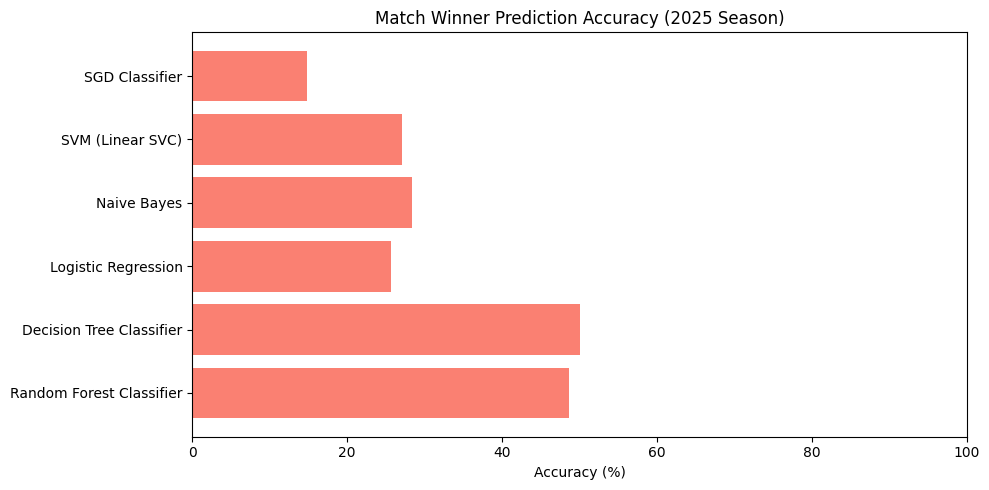

In [14]:

print("\n--- Model Performance Results ---")
for name, score in results.items():
    print(f"{name}: {score}")
    
# Save a simple plot for Classification Accuracy
class_results = {k: float(v.split()[1].strip('%')) for k, v in results.items() if "Accuracy" in v}
if class_results:
    plt.figure(figsize=(10, 5))
    plt.barh(list(class_results.keys()), list(class_results.values()), color='salmon')
    plt.xlabel("Accuracy (%)")
    plt.title("Match Winner Prediction Accuracy (2025 Season)")
    plt.xlim(0, 100)
    plt.tight_layout()
    # plt.savefig('match_prediction_accuracy.png')